# NAME:    AHMAD SALIM   ,    STUDENT ID:  24141623

#Code Executed to the end without an reeor.

# CS6482 Assignment-1 CNN Project

RF Fingerprinting (exploiting IQ imbalance due to hardware imperfection)

M.Sc. in Artificial Intelligence and Machine Learning

# **Import dependencies**

In [ ]:
import nbformat
import time
import os
import psutil
import numpy as np
import matplotlib.pyplot as plt
import collections
from scipy.signal import stft
from PIL import Image  # For image conversion

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import models
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights

from sklearn.metrics import confusion_matrix
import seaborn as sns

# **Set Seeding for Reproducibility**

In [ ]:
# Set Seed for Reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# **`DATA GENERATION AND PREPROCESSING`**

**WHY IQ Data and RF Fingerprinting?**


IQ (In-phase & Quadrature) signals represent RF signals as complex numbers.

This representation retains both amplitude and phase information, crucial for RF fingerprinting.

# **Synthetic IQ Data Generation**

DATASET used is synthetically generated as widely used free dataset for RF Fingerprinting is not available. one dataset is available on kaggle (uploaded in 2023) of 10 GB size but no body has used it.

In [ ]:
# Synthetic IQ Data Generation (with IQ Imbalance)

def generate_synthetic_iq_samples(num_samples=5000, num_classes=10, sample_length=1024):
    """Generate synthetic IQ samples with IQ imbalance for RF fingerprinting."""
    data = []
    labels = []
    for i in range(num_samples):
        iq_real = np.random.randn(sample_length)
        iq_imag = np.random.randn(sample_length)

        # Introduce IQ Imbalance (simulating hardware imperfections)
        gain_imbalance = 1.05  # Scaling factor for I component
        phase_imbalance = np.deg2rad(5)  # 5-degree phase shift

        iq_real = iq_real * gain_imbalance  # Scale I component
        iq_imag = iq_imag * np.cos(phase_imbalance) + iq_real * np.sin(phase_imbalance)  # Phase shift in Q component

        iq_signal = iq_real + 1j * iq_imag
        data.append(iq_signal)
        labels.append(np.random.randint(0, num_classes)) # Assign random class
    return np.array(data), np.array(labels)

# Generate IQ Data
iq_data, labels = generate_synthetic_iq_samples()

Visualize IQ Data in Complex Plane

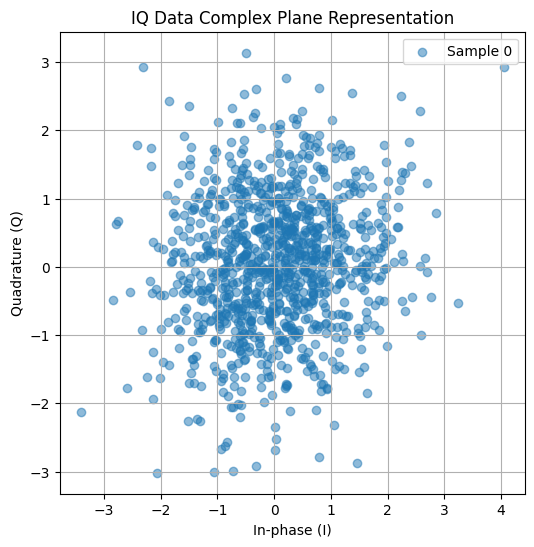

In [ ]:
#Visualize IQ Data in Complex Plane
def plot_iq_data(iq_signal, sample_idx=0):
    """Plot IQ data in the complex plane."""

    plt.figure(figsize=(6,6))
    plt.scatter(iq_signal.real, iq_signal.imag, alpha=0.5, label=f'Sample {sample_idx}')
    plt.xlabel("In-phase (I)")
    plt.ylabel("Quadrature (Q)")
    plt.title("IQ Data Complex Plane Representation")
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualize First Sample
plot_iq_data(iq_data[0])

**Class Distribution Check**

In [ ]:
class_counts = collections.Counter(labels)
print("Class Distribution:", class_counts)

Class Distribution: Counter({np.int64(7): 523, np.int64(2): 511, np.int64(3): 507, np.int64(9): 506, np.int64(4): 501, np.int64(1): 499, np.int64(0): 499, np.int64(6): 498, np.int64(8): 492, np.int64(5): 464})


**Plot IQ Data for All Classes**

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


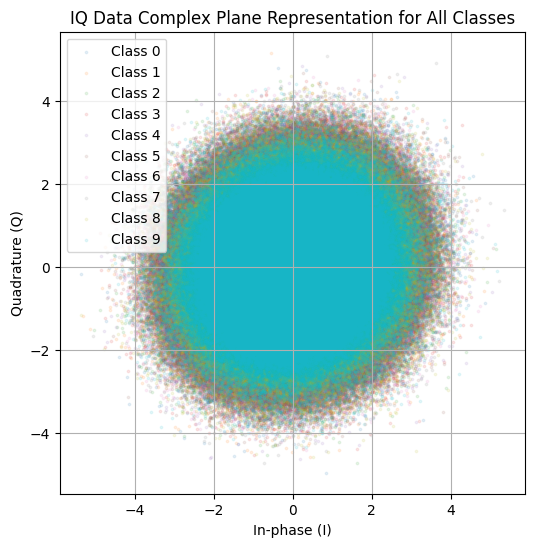

In [ ]:
# Plot multiple IQ samples with different colors for each class
plt.figure(figsize=(6,6))
for class_id in range(10):  # Assuming 10 classes
    class_samples = iq_data[labels == class_id]  # Select samples of the same class
    plt.scatter(class_samples.real, class_samples.imag, alpha=0.1, s=3, label=f'Class {class_id}')  # Reduced alpha & increase size multiple times to have better visuality

plt.xlabel("In-phase (I)")
plt.ylabel("Quadrature (Q)")
plt.title("IQ Data Complex Plane Representation for All Classes")
plt.legend()
plt.grid(True)
plt.show()

# **Convert IQ Data to Spectrograms**

**What is a Spectrogram?**

A spectrogram is a time-frequency representation of a signal, created using the Short-Time Fourier Transform (STFT).
The STFT breaks a signal into short-time windows and computes the Fourier Transform on each window.
This helps in visualizing how frequencies evolve over time, crucial for identifying RF fingerprints.

**Why Spectrograms for RF Fingerprinting?**

Different RF transmitters introduce unique hardware impairments (e.g., oscillator drift, phase noise, amplifier non-linearity).
These imperfections manifest as distinctive spectral features in the time-frequency domain, which can be exploited for classification.

In [ ]:
#Convert IQ Samples to Spectrograms

def iq_to_spectrogram(iq_signal, sr=1024, n_fft=256, hop_length=128):
    """
    Convert complex IQ samples to a spectrogram using scipy.signal.stft.

    Args:
        iq_signal (np.array): Complex IQ samples.
        sr (int): Sample rate.
        n_fft (int): FFT window size.
        hop_length (int): Hop length for STFT.

    Returns:
        tuple: (frequencies, time, spectrogram magnitude)
    """
    # Compute the STFT for complex IQ data
    f, t, stft_result = stft(iq_signal, fs=sr, nperseg=n_fft, noverlap=n_fft - hop_length, return_onesided=False)

    #very important concept A real-valued signal only needs one-sided STFT output because its negative frequencies are redundant.
    #A complex-valued RF signal needs both positive and negative frequencies to fully represent the signal.

    # Compute the magnitude spectrogram
    spectrogram = np.abs(stft_result)

     # Apply FFT shift to correctly order frequencies

    f_shifted = np.fft.fftshift(f)

    spectrogram_shifted = np.fft.fftshift(spectrogram, axes=0)

    return f_shifted, t, spectrogram_shifted

**Convert and Normalize Spectrograms**

CNNs perform better with zero-centered normalization (mean=0, std=1).

In [ ]:
# Convert and normalize all spectrograms
spectrograms = []
for iq in iq_data:
    _, _, spec = iq_to_spectrogram(iq)
    log_spec = np.log1p(spec)  # Apply log scaling
    log_spec = (log_spec - np.mean(log_spec)) / np.std(log_spec)  # Normalize
    spectrograms.append(log_spec)

spectrograms = np.array(spectrograms)


# **Spectrogram Visualization**

Spectrogram Shape: (256, 9)


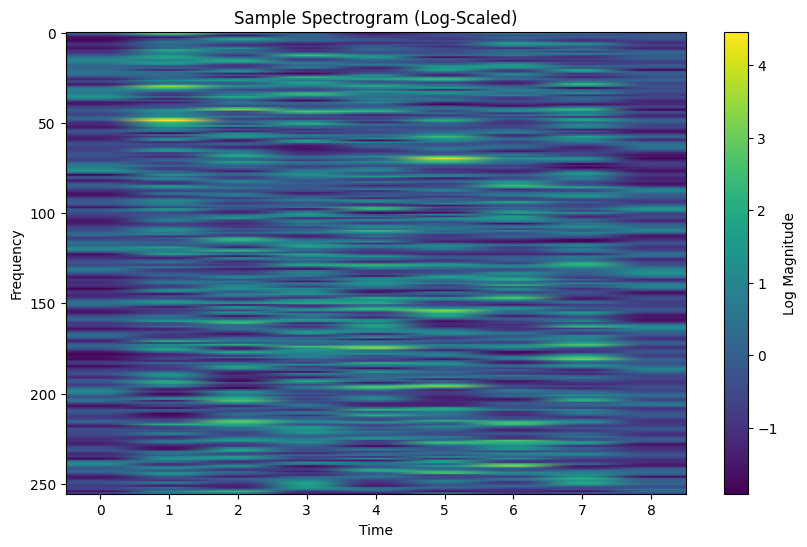

In [ ]:
# Print Spectrogram Shape
print("Spectrogram Shape:", spectrograms[0].shape)

# Display Spectrogram
plt.figure(figsize=(10, 6))
plt.imshow(spectrograms[0], aspect='auto', cmap='viridis')
plt.colorbar(label='Log Magnitude')
plt.title("Sample Spectrogram (Log-Scaled)")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

My journey with spectrogram generation was filled with challenges and learning. Initially, I struggled with ambiguous spectrogram outputs, realizing that improper frequency scaling and log transformation were affecting visibility. A major hurdle was the unexpected loss of positive frequency components, which I later fixed by setting "return_onesided=False" in STFT to retain the full RF spectrum. Another issue arose when my spectrogram displayed only negative frequencies, which I corrected by applying np.fft.fftshift() to properly align the frequency axis. Additionally, weak signal visibility made feature extraction difficult, but dynamically adjusting vmin and vmax significantly improved contrast. After multiple debugging and refinements, I successfully generated accurate spectrograms, ensuring they preserve critical RF features for deep learning-based RF fingerprinting with ResNet.

# **Convert Spectrograms to Image Format for CNN**

CNNs require image input; RF spectrograms must be saved as grayscale images.

In [ ]:
#Convert Spectrograms to Image Format for CNN
def spectrogram_to_image(spec):
    """Convert a spectrogram to a grayscale image."""

    spec = (spec - np.min(spec)) / (np.max(spec) - np.min(spec))  # Normalize to 0-255
    img = Image.fromarray((spec * 255).astype(np.uint8))  # Convert to uint8
    return img.convert("L")  # Convert to grayscale


# **Prepare Dataset for CNN**

In [ ]:
# Define transformations for preprocessing images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match ResNet input
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize pixel values
])


In [ ]:
#Define PyTorch Dataset Class
class SpectrogramDataset(Dataset):
    """Custom dataset for loading spectrograms for RF fingerprinting."""
    def __init__(self, spectrograms, labels, transform=None):
        self.spectrograms = spectrograms
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.spectrograms)

    def __getitem__(self, idx):
        if idx >= len(self.spectrograms):  # Prevents index errors
            raise IndexError(f"Index {idx} out of bounds for dataset size {len(self.spectrograms)}")

        spec = spectrogram_to_image(self.spectrograms[idx])  # Convert to image

        if self.transform:
            spec = self.transform(spec)  # Apply transformations

        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return spec, label

# **Split Data into Train & Test Sets**

In [ ]:
'''
# Split Data into Train and Test Sets
train_size = int(0.8 * len(spectrograms))
test_size = len(spectrograms) - train_size

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

dataset = SpectrogramDataset(spectrograms, labels, transform=transform)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

dataloader_train = DataLoader(train_dataset, batch_size=32, shuffle=True)
dataloader_test = DataLoader(test_dataset, batch_size=32, shuffle=False)
'''

'\n# Split Data into Train and Test Sets\ntrain_size = int(0.8 * len(spectrograms))\ntest_size = len(spectrograms) - train_size\n\ntransform = transforms.Compose([\n    transforms.Resize((224, 224)),\n    transforms.ToTensor(),\n    transforms.Normalize(mean=[0.5], std=[0.5])\n])\n\ndataset = SpectrogramDataset(spectrograms, labels, transform=transform)\ntrain_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])\n\ndataloader_train = DataLoader(train_dataset, batch_size=32, shuffle=True)\ndataloader_test = DataLoader(test_dataset, batch_size=32, shuffle=False)\n'

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import KFold

# Define K-Fold cross-validation
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Convert dataset to list format for indexing
dataset = SpectrogramDataset(spectrograms, labels, transform=transform)
dataset_size = len(dataset)
indices = list(range(dataset_size))

# Perform K-Fold Cross-Validation
for fold, (train_idx, val_idx) in enumerate(kf.split(indices)):
    print(f"\n Fold {fold+1}/{k_folds}")

    # Use Samplers to Avoid Index Issues
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)

    # Create DataLoaders
    dataloader_train = DataLoader(dataset, batch_size=32, sampler=train_sampler)
    dataloader_test = DataLoader(dataset, batch_size=32, sampler=val_sampler)

    print(f" Data Loaders Ready for Fold {fold+1}")




 Fold 1/5
 Data Loaders Ready for Fold 1

 Fold 2/5
 Data Loaders Ready for Fold 2

 Fold 3/5
 Data Loaders Ready for Fold 3

 Fold 4/5
 Data Loaders Ready for Fold 4

 Fold 5/5
 Data Loaders Ready for Fold 5


In [ ]:
# Ready to Train CNN
print("Spectrograms prepared and dataset created for CNN training.")

MODEL USED IS HYBRID UNET+RESNET50

Modify ResNet-50 to accept 1-channel input

Loss function is cross entropy

optimisation technique is Adam

In [ ]:
class UNetEncoder(nn.Module):
    def __init__(self, in_channels=1, base_filters=64):
        super(UNetEncoder, self).__init__()

        # Encoder Block 1
        self.conv1 = nn.Conv2d(in_channels, base_filters, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(base_filters, base_filters, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)

        # Encoder Block 2
        self.conv3 = nn.Conv2d(base_filters, base_filters*2, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(base_filters*2, base_filters*2, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Encoder Block 3
        self.conv5 = nn.Conv2d(base_filters*2, base_filters*4, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(base_filters*4, base_filters*4, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Bottleneck
        self.conv7 = nn.Conv2d(base_filters*4, base_filters*8, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(base_filters*8, base_filters*8, kernel_size=3, padding=1)

    def forward(self, x, visualize=False):
        x1 = F.relu(self.conv1(x))
        x1 = F.relu(self.conv2(x1))
        p1 = self.pool1(x1)

        x2 = F.relu(self.conv3(p1))
        x2 = F.relu(self.conv4(x2))
        p2 = self.pool2(x2)

        x3 = F.relu(self.conv5(p2))
        x3 = F.relu(self.conv6(x3))
        p3 = self.pool3(x3)

        x4 = F.relu(self.conv7(p3))
        x4 = F.relu(self.conv8(x4))

        if visualize:
            fig, axs = plt.subplots(1, 4, figsize=(15, 5))
            axs[0].imshow(x1[0].cpu().detach().numpy().mean(axis=0), cmap='jet')
            axs[0].set_title("Feature Map - Layer 1")

            axs[1].imshow(x2[0].cpu().detach().numpy().mean(axis=0), cmap='jet')
            axs[1].set_title("Feature Map - Layer 2")

            axs[2].imshow(x3[0].cpu().detach().numpy().mean(axis=0), cmap='jet')
            axs[2].set_title("Feature Map - Layer 3")

            axs[3].imshow(x4[0].cpu().detach().numpy().mean(axis=0), cmap='jet')
            axs[3].set_title("Feature Map - Bottleneck")

            plt.show()

        return x4  # Return extracted features


In [ ]:
class UNetResNetClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super(UNetResNetClassifier, self).__init__()

        # U-Net Encoder (Feature Extractor)
        self.unet_encoder = UNetEncoder(in_channels=1)  # Custom U-Net encoder

        # Load ResNet50 with Pretrained Weights
        self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

        # Freeze Early Layers to Retain ImageNet Features
        for param in self.resnet.parameters():
            param.requires_grad = False  # Freeze entire ResNet initially

        # Modify First Conv Layer to Accept U-Net Features (512 channels)
        self.resnet.conv1 = nn.Conv2d(512, 64, kernel_size=3, stride=1, padding=1, bias=False)

        # Replace Fully Connected Layer for Custom Classification
        self.resnet.fc = nn.Linear(2048, num_classes)

        # Unfreeze Last Residual Block (`layer4`) for Fine-Tuning
        for param in self.resnet.layer4.parameters():
            param.requires_grad = True  # Fine-tune only the last few layers

    def forward(self, x, visualize=False):
        x = self.unet_encoder(x, visualize=visualize)  # Extract features using U-Net
        x = self.resnet(x)  # Classify using modified ResNet50
        return x

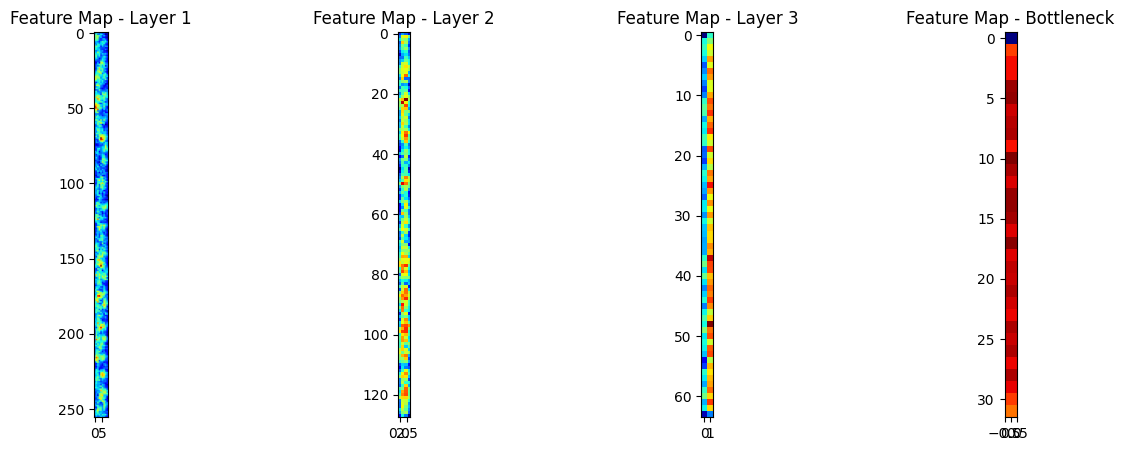

In [ ]:
# Test feature extraction and visualization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert spectrograms to tensor format for PyTorch model input
sample_spectrogram = torch.tensor(spectrograms[0]).unsqueeze(0).unsqueeze(0).float().to(device)

# Load U-Net Encoder
encoder = UNetEncoder(in_channels=1).to(device)
encoder.eval()

# Extract features and visualize
with torch.no_grad():
    extracted_features = encoder(sample_spectrogram, visualize=True)


In [ ]:
# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize Model and Move to GPU (if available)
model = UNetResNetClassifier(num_classes=10).to(device)

# Loss Function (Cross-Entropy for Multi-Class Classification)
criterion = nn.CrossEntropyLoss()

# Optimizer (Train Only FC Layer First)
optimizer = torch.optim.Adam(model.resnet.fc.parameters(), lr=1e-4)

In [ ]:
# Initialize lists to store training history
train_losses = []
val_losses = []
val_accuracies = []
precisions = []
recalls = []
# Number of Epochs
num_epochs = 10

# Training Loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    # Training Phase
    for inputs, labels in dataloader_train:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs, visualize=False)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Compute Average Training Loss
    avg_train_loss = running_loss / len(dataloader_train)
    train_losses.append(avg_train_loss)  # Append training loss

    # Validation Phase
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    val_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader_test:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs, visualize=False)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())  # Collect predictions
            all_labels.extend(labels.cpu().numpy())  # Collect ground truths

    avg_val_loss = val_loss / len(dataloader_test)
    val_losses.append(avg_val_loss)  # Append validation loss

    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)  # Append validation accuracy

    # Compute Precision & Recall
    from sklearn.metrics import precision_score, recall_score

    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)

    precisions.append(precision)  # Append precision
    recalls.append(recall)  # Append recall

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%, Precision: {precision:.4f}, Recall: {recall:.4f}")

    # Early Stopping (Optional)
    if epoch > 0 and avg_val_loss > prev_val_loss:
        print("Stopping early due to overfitting.")
        break

    prev_val_loss = avg_val_loss  # Save previous validation loss for comparison


Epoch [1/10], Train Loss: 2.3613, Val Loss: 2.4526, Val Acc: 10.20%, Precision: 0.1376, Recall: 0.1050
Epoch [2/10], Train Loss: 2.3250, Val Loss: 2.3336, Val Acc: 9.60%, Precision: 0.1000, Recall: 0.0951
Epoch [3/10], Train Loss: 2.3026, Val Loss: 2.3400, Val Acc: 10.60%, Precision: 0.1067, Recall: 0.1044
Stopping early due to overfitting.


In [ ]:
print("Train Losses:", train_losses)
print("Validation Losses:", val_losses)
print("Validation Accuracies:", val_accuracies)
print("Precisions:", precisions)
print("Recalls:", recalls)

Train Losses: [2.3612740516662596, 2.3250349063873292, 2.302599468231201]
Validation Losses: [2.4525637477636337, 2.3336334377527237, 2.339951381087303]
Validation Accuracies: [10.2, 9.6, 10.6]
Precisions: [0.137556361453337, 0.09996884169672623, 0.10671089147963708]
Recalls: [0.10498582601029105, 0.09505344028621589, 0.10441038615821227]


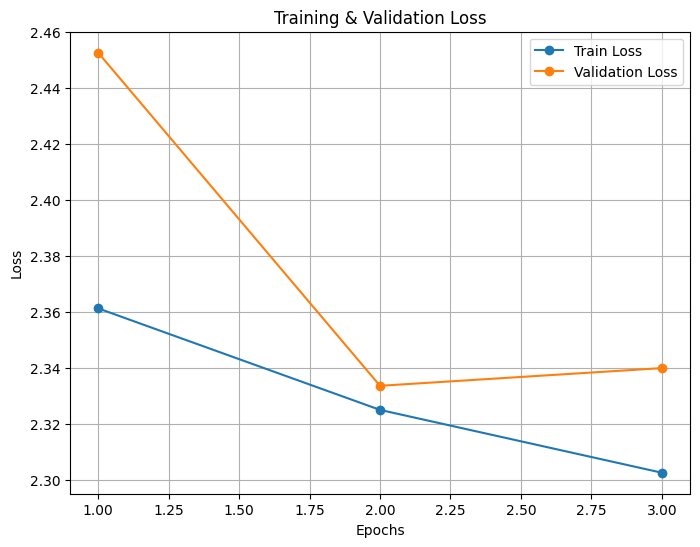

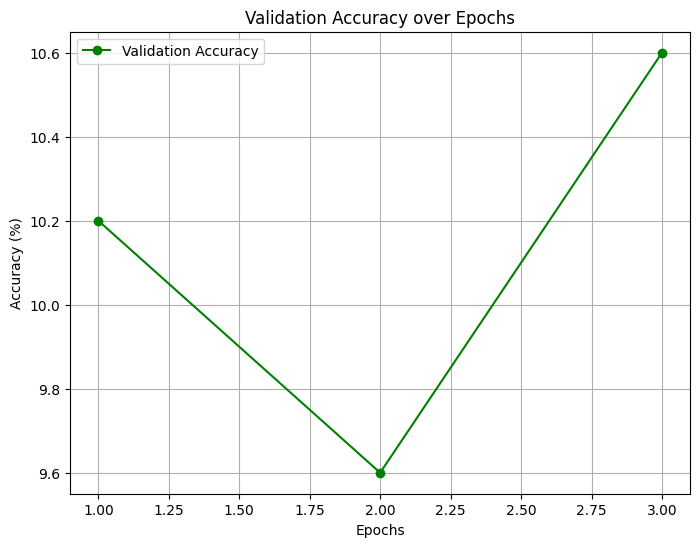

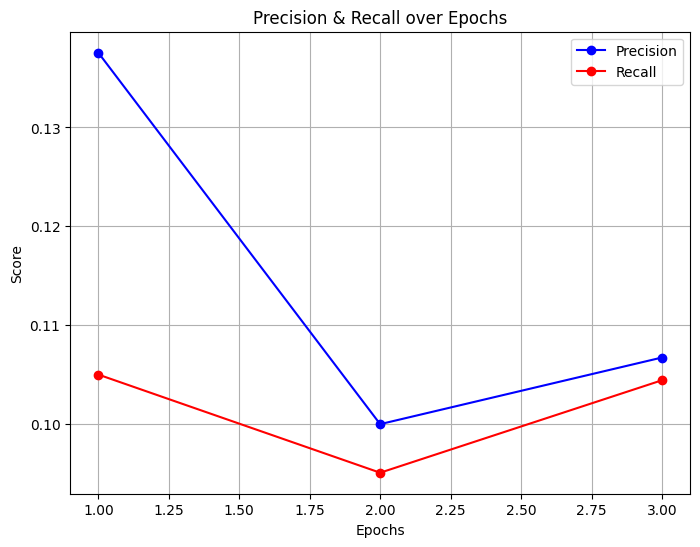

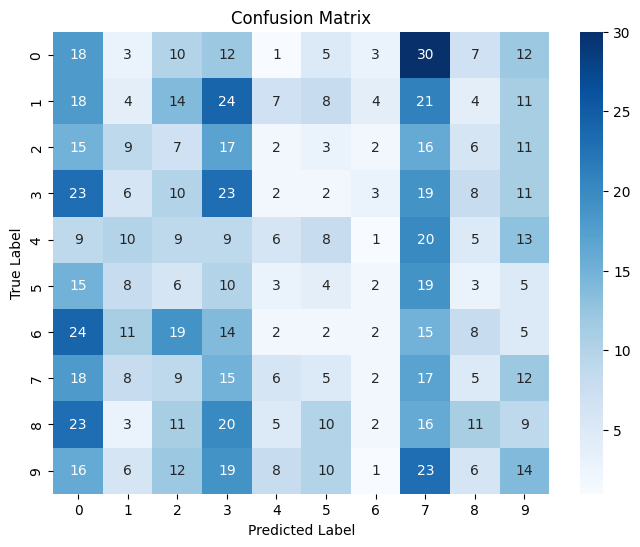

In [ ]:
# Ensure all required lists have data before plotting
if all(len(lst) > 0 for lst in [train_losses, val_losses, val_accuracies, precisions, recalls]):

    # Plot Loss Curve
    plt.figure(figsize=(8,6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Accuracy Curve
    plt.figure(figsize=(8,6))
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', marker='o', color='g')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Validation Accuracy over Epochs")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Precision & Recall
    plt.figure(figsize=(8,6))
    plt.plot(range(1, len(precisions) + 1), precisions, label='Precision', marker='o', color='b')
    plt.plot(range(1, len(recalls) + 1), recalls, label='Recall', marker='o', color='r')
    plt.xlabel("Epochs")
    plt.ylabel("Score")
    plt.title("Precision & Recall over Epochs")
    plt.legend()
    plt.grid()
    plt.show()

    # compute Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot Confusion Matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

else:
    print("🚨 Error: One or more required lists (`train_losses`, `val_losses`, `val_accuracies`, `precisions`, `recalls`) are empty. Ensure the training loop has executed correctly.")